# Hallucination Detection System Pipeline

This notebook demonstrates the core functionality of our mechanistic interpretability-based hallucination detection system for financial statements.

## Pipeline Overview:
1. **Data Preparation**: Load and preprocess financial Q&A data
2. **Steering Vector Extraction**: Extract vectors that differentiate factual vs speculative claims
3. **Hidden State Analysis**: Analyze model internal representations 
4. **Confidence Scoring**: Build confidence scores for financial statements
5. **Evaluation**: Test system performance on sample data

In [12]:
# Core imports for the hallucination detection pipeline
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ Core libraries imported successfully")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Core libraries imported successfully


## 1. Data Preparation and Analysis

In [13]:
# Import existing modules from the core package
import sys
import os
from nnsight import LanguageModel
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'core'))

from steering_vector_extractor import SteeringVectorExtractor
from hallucination_scorer import HallucinationScorer
from main_evaluation import create_steering_data, load_tatqa_samples_split
from auth_utils import get_cache_dir, setup_huggingface_auth

## 3. Initialize Components and Extract Steering Vectors

In [14]:
# Initialize the steering vector extractor with model for demonstration
setup_huggingface_auth()
model = LanguageModel('google/gemma-2-2b-it', cache_dir=get_cache_dir(),torch_dtype=torch.bfloat16, device_map="cuda",dispatch=True)
extractor = SteeringVectorExtractor(model=model)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✓ HuggingFace authentication successful


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


In [15]:
N_SAMPLES = 50
# Extract steering vectors using the sample data
factual_statements, speculative_statements = create_steering_data()
tat_val, tat_test  = load_tatqa_samples_split(N_SAMPLES)
steering_vectors = extractor.compute_mean_difference_vectors(
    factual_statements, 
    speculative_statements
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Loaded and split TAT-QA data: 50 validation, 50 test samples
Extracting activations for factual texts...
Extracting activations for speculative texts...


## 4. Hidden State Analysis and Context Effects

In [16]:
# Initialize the hallucination scorer for hidden state analysis
print("Initializing hallucination scorer...")

scorer = HallucinationScorer(model=model)


Initializing hallucination scorer...


In [6]:
calibration_results = {}
for layer in range(len(extractor.model.model.layers)): 
    calibration_results[layer] = scorer.calibrate_threshold_on_tatqa(
        tat_val,
        steering_vectors=steering_vectors, layer=layer)

Calibrating threshold on 50 validation samples on layer 0.
TAT-QA Calibration Results:
  ROC AUC: 0.528
  Optimal threshold: 1.304
  TPR: 0.278, FPR: 0.094
  Hallucination rate: 0.360
  Mean correct projection: -0.655
  Mean halluc projection: -0.307
Calibrating threshold on 50 validation samples on layer 1.
TAT-QA Calibration Results:
  ROC AUC: 0.516
  Optimal threshold: 1.455
  TPR: 0.389, FPR: 0.156
  Hallucination rate: 0.360
  Mean correct projection: -0.354
  Mean halluc projection: -0.234
Calibrating threshold on 50 validation samples on layer 2.
TAT-QA Calibration Results:
  ROC AUC: 0.540
  Optimal threshold: 6.657
  TPR: 0.444, FPR: 0.219
  Hallucination rate: 0.360
  Mean correct projection: 4.635
  Mean halluc projection: 4.382
Calibrating threshold on 50 validation samples on layer 3.
TAT-QA Calibration Results:
  ROC AUC: 0.582
  Optimal threshold: 6.381
  TPR: 0.444, FPR: 0.188
  Hallucination rate: 0.360
  Mean correct projection: 3.246
  Mean halluc projection: 3.729


## The most effective layers for hallucination detection occur between layers 12 and 18.
Interestingly, the magnitude of the steering vector does not correlate well with detection performance. 

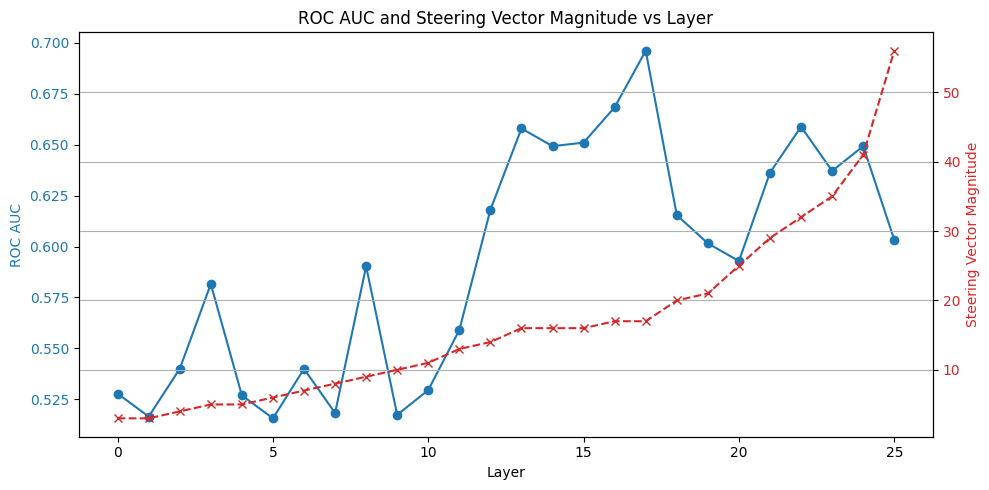

In [8]:
# Prepare correct axes: layer on x-axis, roc_auc and magnitude as two y-axis series

# Reuse layer IDs from the dictionaries
layers = sorted(calibration_results.keys())
roc_aucs = [calibration_results[l]['roc_auc'] for l in layers]
magnitudes = [steering_vectors[l].vector.norm().int().cpu() for l in layers]

# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

color_roc = 'tab:blue'
ax1.set_xlabel("Layer")
ax1.set_ylabel("ROC AUC", color=color_roc)
ax1.plot(layers, roc_aucs, color=color_roc, marker='o', label='ROC AUC')
ax1.tick_params(axis='y', labelcolor=color_roc)

# Create a second y-axis for the magnitudes
ax2 = ax1.twinx()
color_mag = 'tab:red'
ax2.set_ylabel("Steering Vector Magnitude", color=color_mag)
ax2.plot(layers, magnitudes, color=color_mag, marker='x', linestyle='--', label='Magnitude')
ax2.tick_params(axis='y', labelcolor=color_mag)

plt.title("ROC AUC and Steering Vector Magnitude vs Layer")
fig.tight_layout()
plt.grid(True)
plt.show()


In [17]:
layer = 17
calibration_results = scorer.calibrate_threshold_on_tatqa(
        tat_val,
        steering_vectors=steering_vectors, layer=layer)

Calibrating threshold on 50 validation samples on layer 17.
TAT-QA Calibration Results:
  ROC AUC: 0.639
  Optimal threshold: 15.776
  TPR: 0.438, FPR: 0.059
  Hallucination rate: 0.320
  Mean correct projection: 6.589
  Mean halluc projection: 10.112


## 5. Confidence Scoring System for Financial Statements

In [18]:
results = scorer.evaluate_hallucination_detection_on_tatqa(
    tat_test, 
    steering_vectors=steering_vectors, 
    calibrated_threshold=calibration_results['optimal_threshold'], layer=layer
)

Evaluating hallucination detection on 50 test samples...
Using layer 17 for hallucination detection evaluation.

Hallucination Detection Results:
Model Accuracy: 0.660
Hallucination Rate: 0.340
Detection Accuracy: 0.680
Detection Precision: 0.545
Detection Recall: 0.353
